In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})
pd.options.display.float_format = '{:.2f}'.format

colors = {
    'blue_light': (0.1, 0.3, 0.7, 0.7),
    'blue': (0.1, 0.3, 0.7, 0.9),
    'blue_strong': (0.1, 0.3, 0.7, 1.0)
    }

In [2]:
df_wiki = pd.read_csv("input/train_2.csv")
df_wiki = df_wiki.set_index("Page")

df_wiki.columns = pd.to_datetime(df_wiki.columns)
df_wiki = df_wiki.astype('float')

# Data Exploration

**Checks for duplicated data**:

In [3]:
df_wiki.axes[0].duplicated().any()

False

In [4]:
df_wiki.axes[1].duplicated().any()

False

**Check for missing data:** 

A tolerance of 6% missing data is acceptable. Some of these gaps arise from instances where a wiki page records zero visits, which is normal.  
Additionally, certain pages may show appearances or disappearances within the test time range, resulting in leading or trailing NA values.

In [5]:
df_wiki.isna().mean().mean()

0.0603280462444157

In [6]:
df_wiki.loc[df_wiki.isna().any(axis=1), :][0:3]

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Page,,,,,,,,,,,,,,,,,,,,,
52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.00,16.00,19.00,9.00,20.00,23.00,28.00,14.00,8.00,7.00
91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.00,8.00,5.00,7.00,8.00,10.00,8.00,5.00,3.00,5.00
ASTRO_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN,NaN,...,17.00,17.00,25.00,4.00,29.00,14.00,44.00,62.00,47.00,16.00


The missing data ratio gradually decreases over the examined period, with **strong fluctuations occuring in the last 2-3 months.**  
The total visits display a gradual increase, corresponding to the decrease in missing data, with **significant peeks observed.**

The fluctuations and peaks underwent further examination.

<Axes: title={'center': 'Total visits'}>

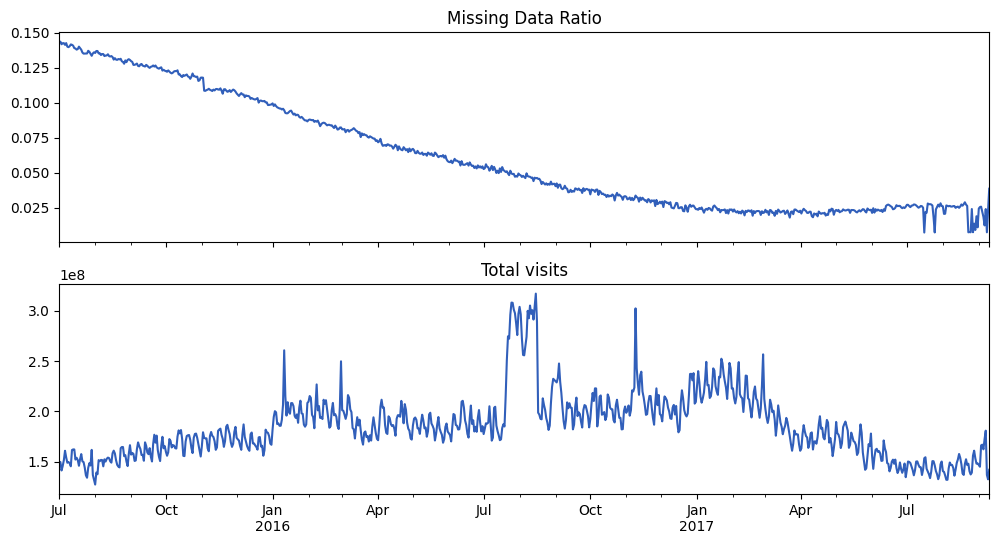

In [7]:
pfig, paxes = plt.subplots(2, 1, figsize=(12,6), sharex=True)

df_wiki.isna().mean().plot(ax=paxes[0], title='Missing Data Ratio', color=colors['blue'])
df_wiki.sum().plot(ax=paxes[1], title='Total visits', color=colors['blue'])

There are two significant dips in the missing data ratio observed on **2017-07-16** and **2017-07-25**.  
However, the exceptionally high ratio of visited pages does not allign with any peek in total visits  
Additionally, there is substantial **turbulence in the data throughout 2017-09**.  

Given the complexity and difficulty in explaining these phenomena, the entire period from 2017-07-01 will be categorized as outliers and excluded from model training.

,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28
sum,3789,3761,3597,1037,3170,3088,4045,3969,3977,3943,3839,2622,1047,3429,3688,3927


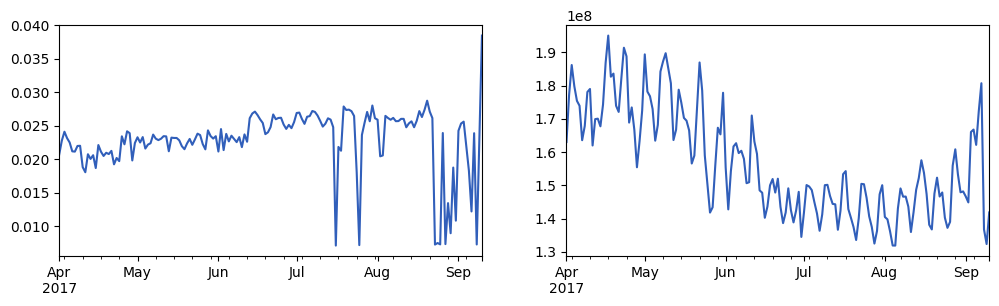

In [8]:
pfig, paxes = plt.subplots(1, 2, figsize=(12,3))

df_wiki.loc[:, "2017-04-01":].isna().mean().plot(ax=paxes[0], color=colors['blue'])
df_wiki.loc[:, "2017-04-01":].sum().plot(ax=paxes[1], color=colors['blue'])

df_wiki.loc[:, "2017-07-13":"2017-07-28"].isna().agg(["sum"])

There are several seasonal peaks and drops that appear to be normal, indicating seasonal patterns. However, one notably suspicious pattern stands out:  
There is a substantial peak in Total and Max visits during 2016-07 and 2016-08 without a corresponding increase in median visits, suggesting the possibility of a small number of large outliers.

<Axes: ylabel='Max visits'>

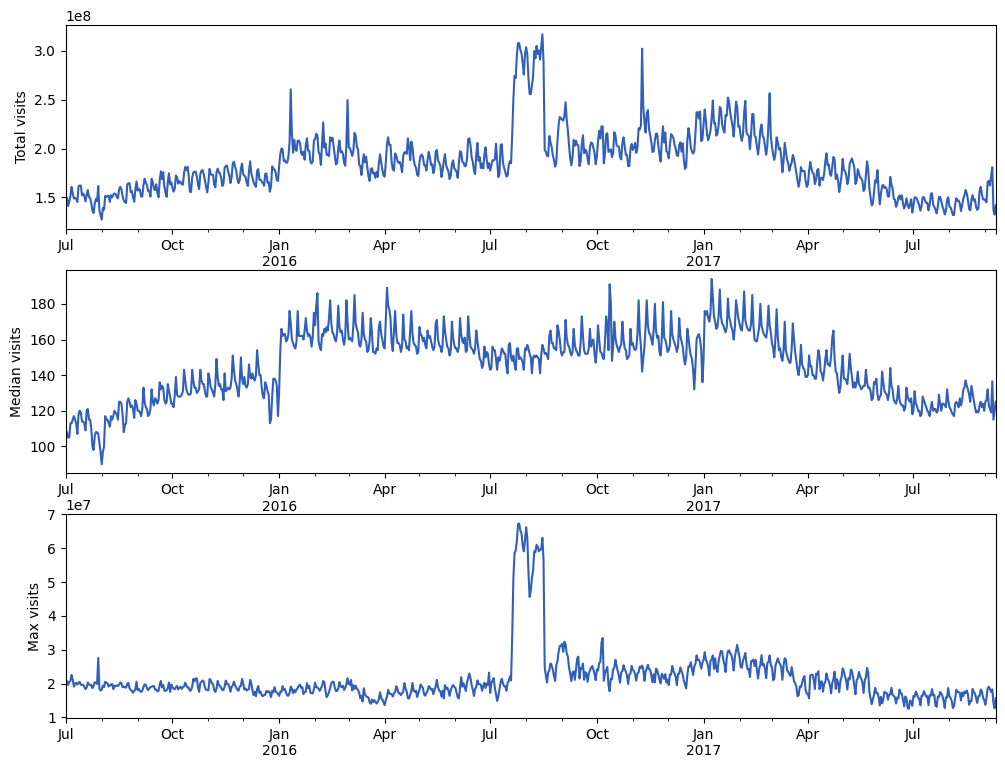

In [9]:
pfig, paxes = plt.subplots(3, 1, figsize=(12,9))

df_wiki.sum().plot(ax=paxes[0], ylabel='Total visits', color=colors['blue'])
df_wiki.median().plot(ax=paxes[1], ylabel='Median visits', color=colors['blue'])
df_wiki.max().plot(ax=paxes[2], ylabel='Max visits', color=colors['blue'])

The hypothesis regarding outliers in 2016-07 - 2016-08 seems accurate.  
There are two records of Wikipedia's English main page showing unusually high values for precisely 1 month (from 2016-07-18 to 2016-08-18).  

This discrepancy should be excluded from model training. Given the assumed significance of Wikipedia's English main page, instead of removing all the data for this records, I filled in the missing values using interpolation for this specific outlier period.

Text(0.5, 1.0, 'Number of outlier pages: 2\nMain_Page_en.wikipedia.org_desktop_all-agents\nMain_Page_en.wikipedia.org_all-access_all-agents')

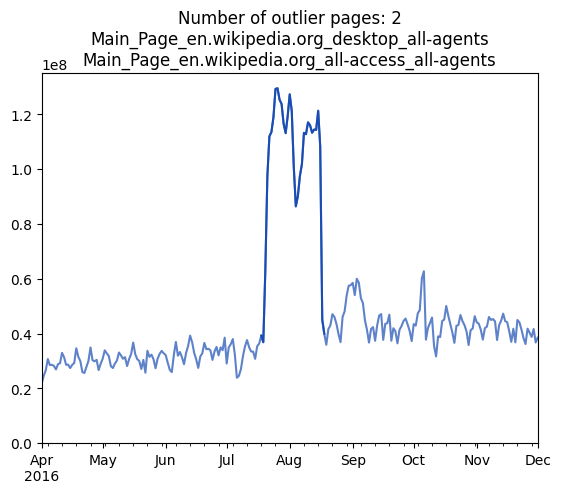

In [10]:
max_per_page = df_wiki.loc[:,"2016-07-01":"2016-09-01"].max(axis=1)

outlier_pages = max_per_page[max_per_page >= 4e7].index

df_wiki.loc[outlier_pages, "2016-04-01":"2016-12-01"].sum().plot(ylim=0, color=colors['blue_light'])
df_wiki.loc[outlier_pages, "2016-07-18":"2016-08-18"].sum().plot(ylim=0, color=colors['blue_strong'])
plt.title(f"Number of outlier pages: {len(outlier_pages)}\n{outlier_pages[0]}\n{outlier_pages[1]}")


**Examine distribution**

The visits data exhibits an extremely skewed distribution, making it barely visible when plotted on a histogram using a linear scale.
To address this issue, we apply a logarithmic transformation using the *log(x+1)* function.
This transformation helps the model in emphasizing detailed patterns and interpreting peaks and drops in terms of their relative magnitudes.  

The median visits display substantial variations among different groups (as depicted below). 
This observation shows that the model needs to forecast traffic for various types of pages, such as smaller obscure pages, intermittently popular pages, extensively visited pages, and exceptionally large pages like the main page. 
To capture the diverse behaviors among these distinct classes, I will utilize the normalized logarithm of median visits as a feature.

<Axes: >

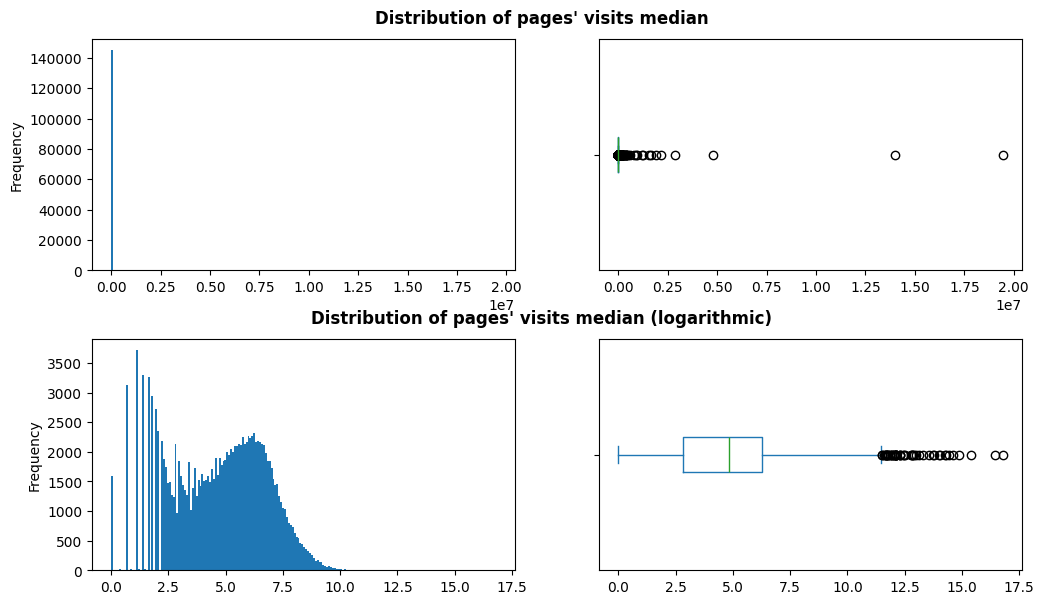

In [11]:
wiki_median = df_wiki.median(axis=1)
wiki_median_log = wiki_median.apply(np.log1p)

fig = plt.figure(figsize=(12,6))

subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle("Distribution of pages' visits median", fontweight='bold')

axs0 = subfigs[0].subplots(1, 2)

wiki_median.plot.hist(bins=200, ax=axs0[0])
wiki_median.plot.box(ax=axs0[1], vert=False, label='')

axs1 = subfigs[1].subplots(1, 2)

subfigs[1].suptitle("Distribution of pages' visits median (logarithmic)", fontweight='bold')

wiki_median_log.plot.hist(bins=200, ax=axs1[0])
wiki_median_log.plot.box(ax=axs1[1], vert=False, label='')

**Data normalization**

To improve the learning process visits data was scaled.
I used a simple normalization by a maximum value separate for each page:
- to train the model based on values in a range of (0,1)
- so each page has similar impact on the loss function, regardless of its traffic magnitude
- to not shift the data (logarithmic function was already applied)
- as we assume that 0 is a minimum traffic value for each page (there's no point in deriving minimum value from data)

(0.0, 1.0388137911636968)

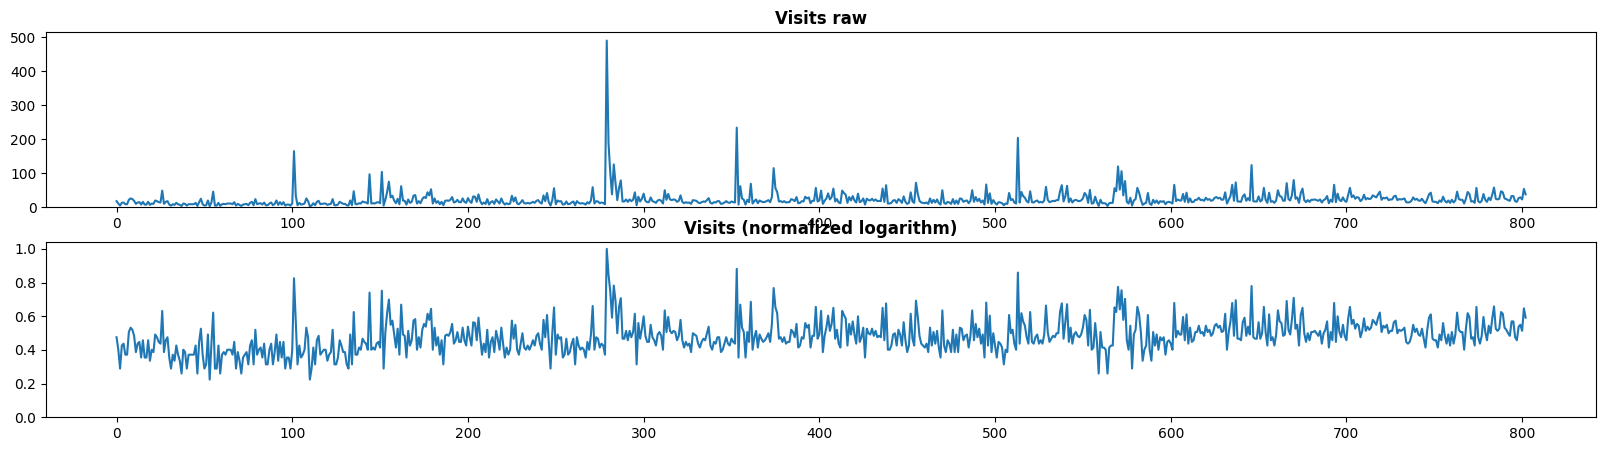

In [12]:
from project_functions.normalization import MaxAbsLogScaler

scaler = MaxAbsLogScaler()

i_page = df_wiki.iloc[0, :].to_numpy().reshape(1, -1)
i_page_scaled = scaler.fit_transform(i_page)

fig, ax = plt.subplots(2, 1, figsize=(20,5))

ax[0].plot(i_page[0, :])
ax[0].set_title('Visits raw', fontweight='bold')
ax[0].set_ylim(0)

ax[1].plot(i_page_scaled[0, :])
ax[1].set_title('Visits (normalized logarithm)', fontweight='bold')
ax[1].set_ylim(0)

**Loss function**

Despite the transformations mentioned earlier, certain significant peeks remain unpredictable due to their unknown nature.  
To mitigate their influence during training, I applied Huber loss function.

The Delta parameter for Huber Loss is determined through the following steps:
- Compute the logarithm of normalized visits.
- Calculate the standard deviation for each page.
- Derive the median standard deviation across all pages.
- Set Delta as 3 times the calculated median standard deviation (rule of thumb for the outlier treshold).

0.24760805716476292

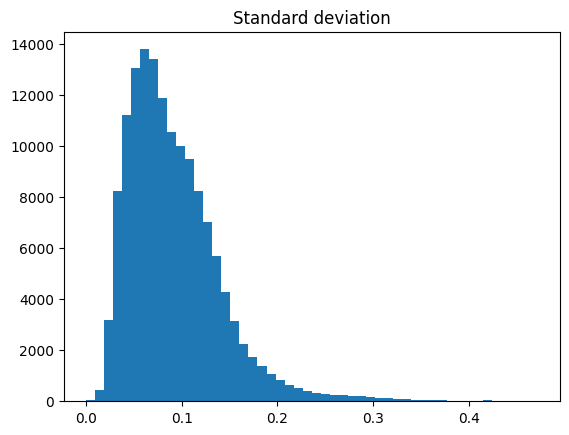

In [13]:
multi_scaler = MaxAbsLogScaler()

all_pages = df_wiki.to_numpy()
all_pages_scaled = multi_scaler.fit_transform(all_pages)

stds = np.nanstd(all_pages_scaled, axis=1) 
plt.hist(stds, bins=50)
plt.title('Standard deviation')

np.median(stds) * 3

**Check for seasonality:**  

I conducted an autocorrelation analysis on the number of visits across all pages to identify any seasonal patterns. Two distinct seasonal patterns were observed:
- weekly
- yearly

To enhance the model's capability in capturing seasonal patterns for predictions, I included additional time features including:
- Sine and cosine waves with periods of 7 and 365 days
- Autocorrelation of page visits lagged with intervals of 7 and 365 days

Finally, due to the limited duration of available data (only about 2 years), only the weekly seasonality was incorporated into the model. Modeling yearly seasonality with such a short period was unfeasible.

/home/bs/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


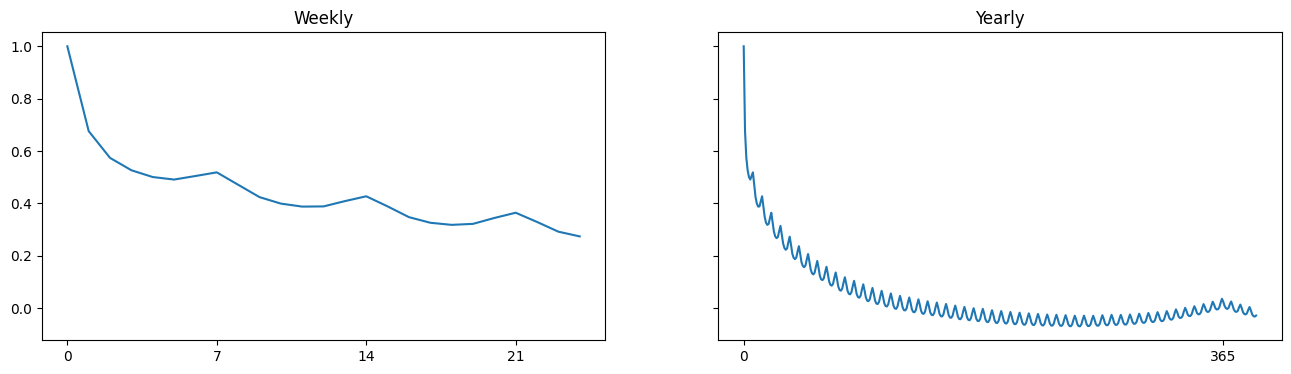

In [14]:
import statsmodels.api as sm

autocorrs = np.apply_along_axis(
    func1d=lambda arr, nlags: sm.tsa.acf(x=arr, nlags=nlags, missing='conservative'), 
    axis=1,    
    arr=all_pages_scaled, 
    nlags=390
    )

avg_autocorrs = autocorrs.mean(axis=0, where=~np.isnan(autocorrs))

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 4))

ax[0].plot(avg_autocorrs[0:25])
ax[0].set_xticks(range(0, 25, 7))
ax[0].set_title("Weekly")

ax[1].plot(avg_autocorrs)
ax[1].set_xticks(range(0, 391, 365))
ax[1].set_title("Yearly")

plt.show()

**Exploration of page information**

As per the problem's description:  
*"The page names contain the Wikipedia project (e.g. en.wikipedia.org), type of access (e.g. desktop) and type of agent (e.g. spider).  
In other words, each article name has the following format: 'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider')."*

Regarding these features:
- The features were extracted and analyzed to assess their utility for the model.
- The project, access, and agent features were included in the model as they represent factor variables with a few levels, making them suitable for OneHotEncoding.
- The page names were excluded from the model due to the high volume of unique values (49k out of 145k rows), making their incorporation challenging. While page names under different agents or access types might exhibit common behavior, the limited data available for each level (usually 2-3 rows) raises concerns about potential overfitting. Therefore, the usefulness of this feature remains questionable.

In [15]:
extract_groups = [
    r'(?P<page_name>^.*(?=_))'
    r'(?P<junk_1>_)',
    r'(?P<project>(?<=_)[^_]*(?=_))', 
    r'(?P<junk_2>_)',
    r'(?P<access>(?<=_)[^_]*(?=_))', 
    r'(?P<junk_3>_)', 
    r'(?P<agent>(?<=_).*$)'
    ]

page_features = df_wiki.index. \
    str.extract("".join(extract_groups)). \
    drop(columns=['junk_1', 'junk_2', 'junk_3'])

In [16]:
page_features.describe().iloc[0:2]

,page_name,project,access,agent
count,145063,145063,145063,145063
unique,49174,9,3,2


In [17]:
print(
    "\n------------------------------\n",
    page_features.project.value_counts(), 
    "\n------------------------------\n",
    page_features.access.value_counts(), 
    "\n------------------------------\n", 
    page_features.agent.value_counts(),
    "\n------------------------------\n")


------------------------------
 project
en.wikipedia.org         24108
ja.wikipedia.org         20431
de.wikipedia.org         18547
fr.wikipedia.org         17802
zh.wikipedia.org         17229
ru.wikipedia.org         15022
es.wikipedia.org         14069
commons.wikimedia.org    10555
www.mediawiki.org         7300
Name: count, dtype: int64 
------------------------------
 access
all-access    74315
mobile-web    35939
desktop       34809
Name: count, dtype: int64 
------------------------------
 agent
all-agents    110150
spider         34913
Name: count, dtype: int64 
------------------------------



**Conclusions:**

1. Exclude the Main Page data between 2016-07-18 and 2016-08-18
2. Exclude the entire period starting from 2017-07-01
3. Apply a logarithmic function and normalize visits data using the maximum absolute value.
4. Use Huber loss function with a delta value of 0.25.
5. Utilize the normalized logarithm of page median visits as a feature representing the magnitude of traffic for each page.
6. Incorporate additional time features, represented by sine and cosine waves with period of 7 and autocorrelation of page visits lagged with interval of 7 days.
7. Include additional one-hot-encoded page features: project, access and agent.